<a href="https://colab.research.google.com/github/StanislavVII/Twitter-Sentiment/blob/main/K_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Python Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
#Loading the data
data = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", on_bad_lines="skip")
data.columns = ["label", "time", "date", "query", "username", "text"]

In [ ]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [ ]:
print('lenght of data is', len(data))

lenght of data is 1599999


In [ ]:
data.shape

(1599999, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [ ]:
np.sum(data.isnull().any(axis=1))

0

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))
print('Count of rows in the data is:  ', len(data))

Count of columns in the data is:   6
Count of rows in the data is:   1599999


## **Data Preparation**

In [ ]:
#Selecting the text and label coloumn
data=data[['text','label']]

In [ ]:
#Assigning 1 to Positive sentiment
data['label'][data['label']==4]=1

In [ ]:
#Separating positive and negative tweets
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
#taking 40 000 tweets
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
#Combining positive and negative tweets
data = pd.concat([data_pos, data_neg])

In [ ]:
#Making statement text in lower case
data['text']=data['text'].str.lower()
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [ ]:
#removing Stop words
stopwords_list = stopwords.words('english')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
#removing the above stop words list from the tweet text
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [ ]:
#removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [ ]:
#removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
#removing email
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
#removing URL's
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [ ]:
#removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [ ]:
#tokenization of tweet text
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
#Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
#Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [ ]:
#Separating input feature and label
X=data.text
y=data.label

In [ ]:
#Preparing the input features for training
#converting the text words into arrays form.
#Maximum 500 features/words selected for training. These 500 words will be selected on the importance that will distinguish between the positive tweets and negative tweets.
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
#total 40000 tweets and the number words/features are 500.
sequences_matrix.shape

(40000, 500)

In [ ]:
#Separating the 70% data for training data and 30% for testing data
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

# **Implementing Tensorflow based model for training**

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = tensorflow_based_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=10, validation_split=0.1)
print('Training finished !!')

Epoch 1/10
315/315 [==============================] - 128s 405ms/step - loss: 0.5100 - accuracy: 0.7516 - val_loss: 0.5184 - val_accuracy: 0.7457
Epoch 2/10
315/315 [==============================] - 119s 378ms/step - loss: 0.4951 - accuracy: 0.7645 - val_loss: 0.5165 - val_accuracy: 0.7457
Epoch 3/10
315/315 [==============================] - 119s 377ms/step - loss: 0.4851 - accuracy: 0.7690 - val_loss: 0.5235 - val_accuracy: 0.7414
Epoch 4/10
315/315 [==============================] - 121s 384ms/step - loss: 0.4702 - accuracy: 0.7763 - val_loss: 0.5264 - val_accuracy: 0.7389
Epoch 5/10
315/315 [==============================] - 131s 416ms/step - loss: 0.4594 - accuracy: 0.7810 - val_loss: 0.5329 - val_accuracy: 0.7375
Epoch 6/10
315/315 [==============================] - 123s 390ms/step - loss: 0.4501 - accuracy: 0.7887 - val_loss: 0.5547 - val_accuracy: 0.7371
Epoch 7/10
315/315 [==============================] - 122s 388ms/step - loss: 0.4459 - accuracy: 0.7905 - val_loss: 0.5473 -

In [ ]:
accr1 = model.evaluate(X_test,Y_test)

375/375 [==============================] - 25s 63ms/step - loss: 0.5560 - accuracy: 0.7347


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

Test set
  Accuracy: 0.73


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

375/375 [==============================] - 26s 68ms/step




confusion matrix


[[4352 1657]
 [1526 4465]]




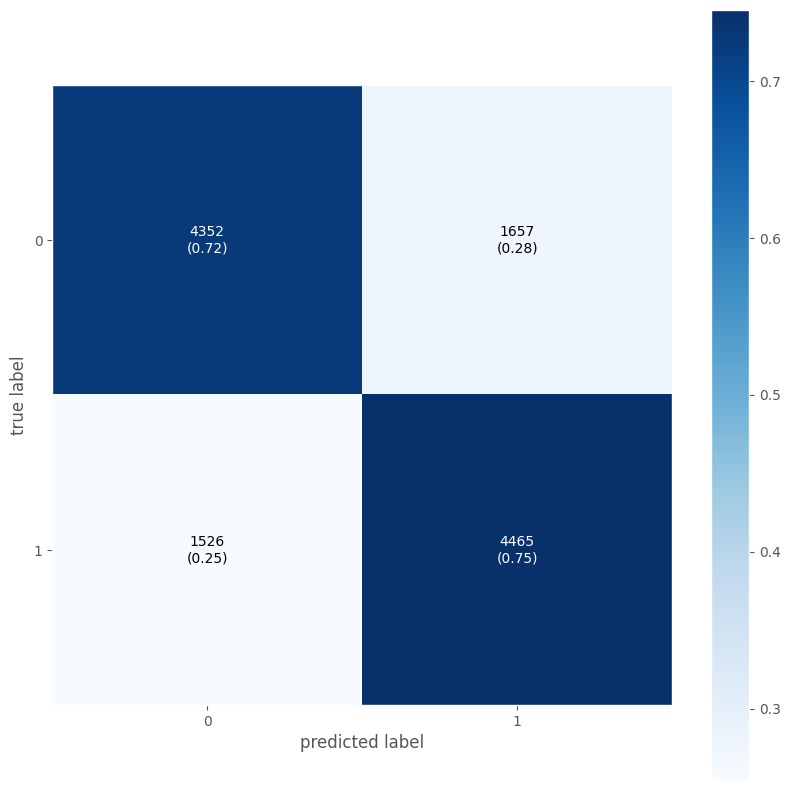

In [ ]:
#Confusion matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
def preprocess_tweet(tweet):
    # Convert to lower case
    tweet = tweet.lower()
    # Remove stop words
    tweet = " ".join([word for word in tweet.split() if word not in STOPWORDS])
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', punctuations_list))
    # Remove repeating characters
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    # Remove emails
    tweet = re.sub('@[^\s]+', ' ', tweet)
    # Remove URLs
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    # Tokenize
    tweet = tokenizer.tokenize(tweet)
    # stemming
    tweet = [st.stem(word) for word in tweet]
    # lemmatization
    tweet = [lm.lemmatize(word) for word in tweet]
    print(tweet)
    return tweet

def predict_sentiment(tweet):
    processed_tweet = preprocess_tweet(tweet)
    tweet_sequence = tok.texts_to_sequences([processed_tweet])
    tweet_sequence_matrix = sequence.pad_sequences(tweet_sequence, maxlen=max_len)
    prediction = model.predict(tweet_sequence_matrix)
    return "Positive" if prediction > 0.5 else "Negative"

new_tweet = "I am very happy with the service!"
sentiment = predict_sentiment(new_tweet)
print(f"The sentiment of the tweet is: {sentiment}")

new_tweet = "The food is bad!"
sentiment = predict_sentiment(new_tweet)
print(f"The sentiment of the tweet is: {sentiment}")

['hapi', 'servic']
1/1 [==============================] - 0s 40ms/step
The sentiment of the tweet is: Positive
['fod', 'bad']
1/1 [==============================] - 0s 35ms/step
The sentiment of the tweet is: Negative
